## Stock Market Prediction Using ARIMA in Python

### Finance Analytics Project



In [26]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
df = pd.read_csv('HCLTECH.NS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-21,408.500000,410.725006,403.899994,406.375000,358.572723,1780310
1,2017-04-24,406.500000,412.000000,404.625000,409.774994,361.572754,1373968
2,2017-04-25,412.000000,412.924988,406.799988,409.975006,361.749268,2194602
3,2017-04-26,410.950012,411.000000,398.274994,400.125000,353.057892,1918248
4,2017-04-27,398.500000,410.000000,398.100006,404.850006,357.227112,5640334


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1235 non-null   object 
 1   Open       1235 non-null   float64
 2   High       1235 non-null   float64
 3   Low        1235 non-null   float64
 4   Close      1235 non-null   float64
 5   Adj Close  1235 non-null   float64
 6   Volume     1235 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.7+ KB


### Data Cleaning and Transformation

#### Removing duplicated date values if any

In [29]:
df[df["Date"].duplicated(keep = False)]
df = df[~df["Date"].duplicated()]

#### Null check to identify missing values

In [30]:
df.isnull().sum()/len(df)

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

#### Transforming 'Date' column to index

In [31]:
df.index = pd.to_datetime(df["Date"])
data = df[df.columns[1:]]
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-21,408.500000,410.725006,403.899994,406.375000,358.572723,1780310
2017-04-24,406.500000,412.000000,404.625000,409.774994,361.572754,1373968
2017-04-25,412.000000,412.924988,406.799988,409.975006,361.749268,2194602
2017-04-26,410.950012,411.000000,398.274994,400.125000,353.057892,1918248
2017-04-27,398.500000,410.000000,398.100006,404.850006,357.227112,5640334


### Data Visualization

#### We consider 'Adj Close' column to predict the future stock price, and it looks like below:

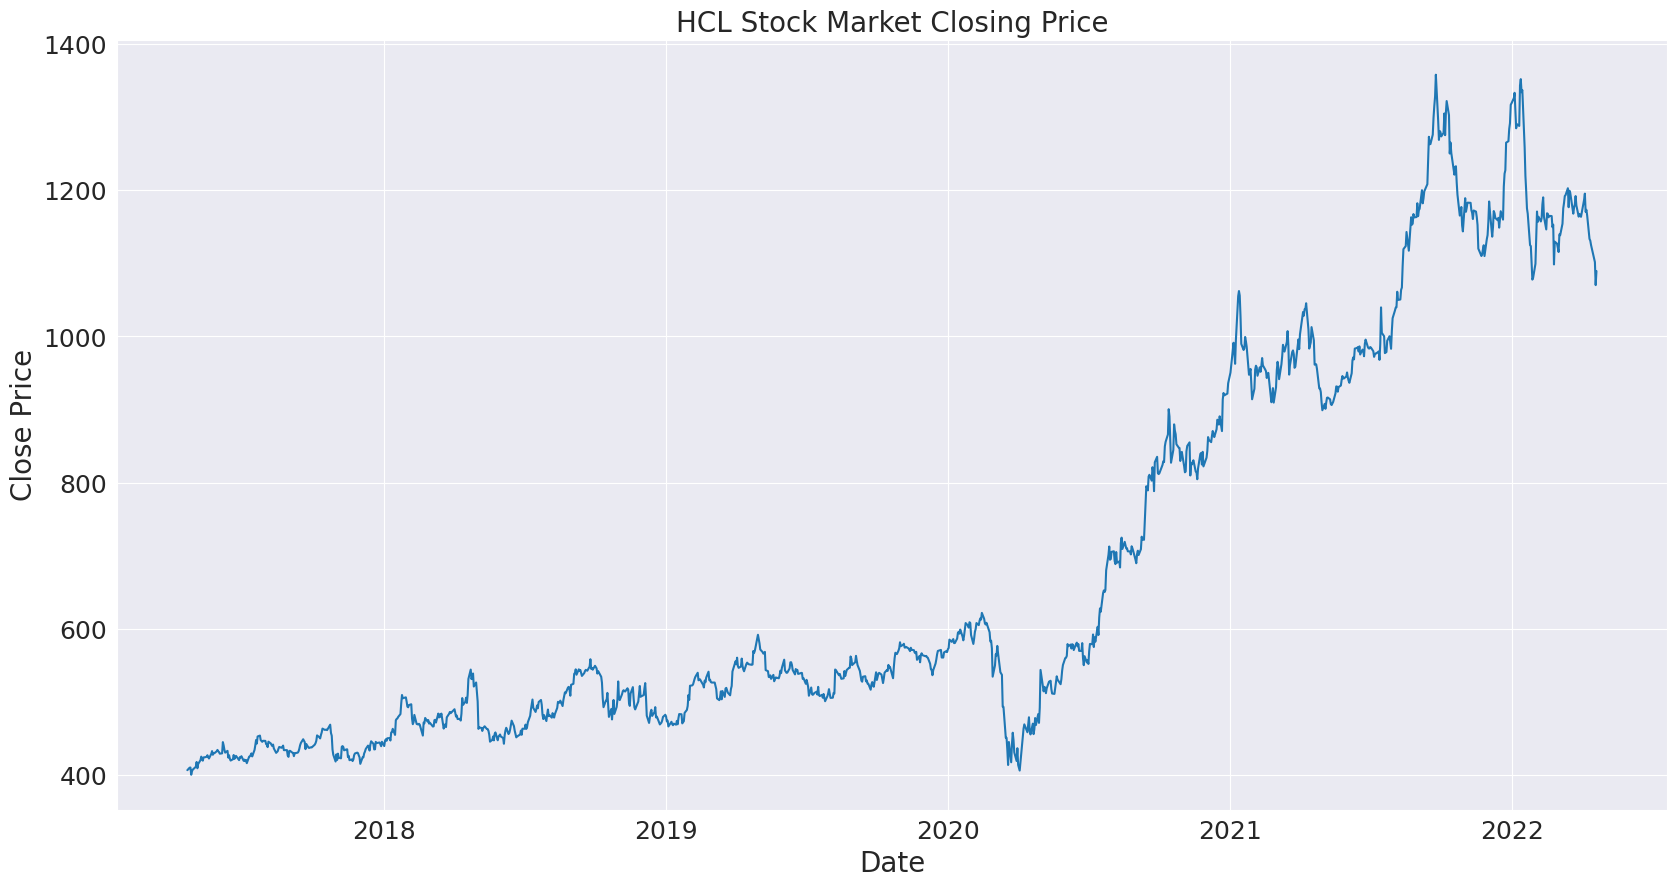

In [32]:
plt.figure(figsize = (20, 10))
sns.set_style('darkgrid')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Close Price', fontsize = 20)
plt.title('HCL Stock Market Closing Price', fontsize = 20)
plt.plot(data['Close'])
plt.tick_params(axis = 'x', labelsize = 18)
plt.tick_params(axis = 'y', labelsize = 18)
plt.savefig('AdjClose_TimeSeriesPlot.png')

### ADF Test to check if data is Stationary or not

In [33]:
def test_adf(timeseries):
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    plt.figure(figsize = (20,10))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(moving_average, color = 'red', label = 'Rolling Mean')
    plt.plot(moving_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best', fontsize = 18)
    plt.title('Rolling Mean and Standard Deviation', fontsize = 20)
    plt.tick_params(axis = 'x', labelsize = 18)
    plt.tick_params(axis = 'y', labelsize = 18)
    plt.savefig('ADFTest2.png')
    plt.show(block = False)
    print("Results of Dicky Fuller Test")
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output['Critical value (%s)' %key] = value
    print(output)

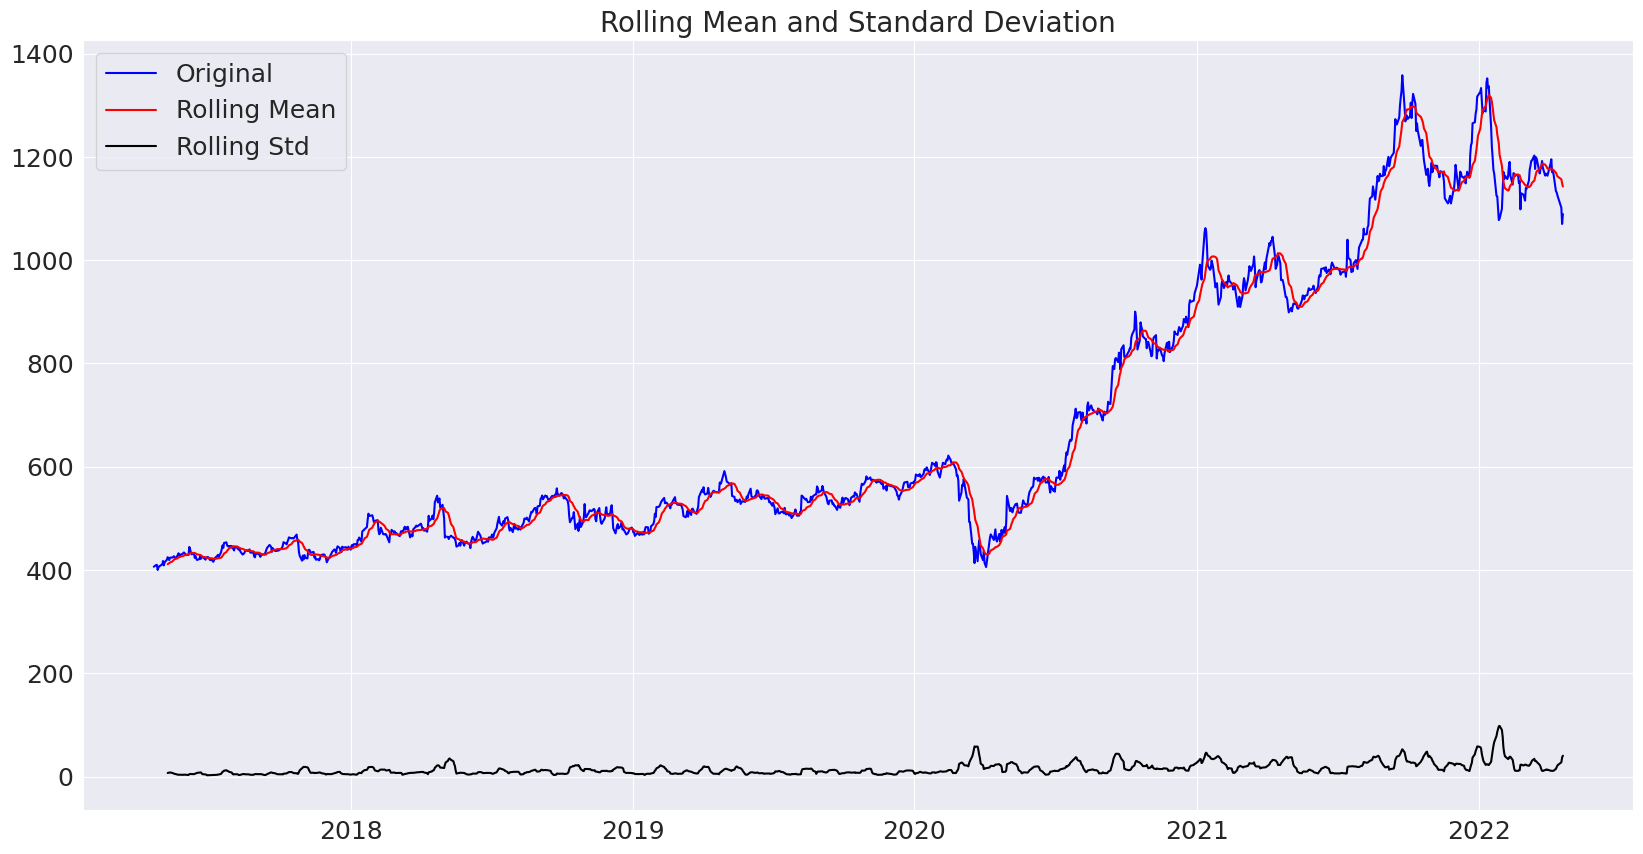

Results of Dicky Fuller Test
Test Statistics                  -0.684578
p-value                           0.850704
No. of lags used                  7.000000
Number of observations used    1227.000000
Critical value (1%)              -3.435691
Critical value (5%)              -2.863898
Critical value (10%)             -2.568026
dtype: float64


In [34]:
test_adf(data['Close'])

##### From the above result, it is evident that test Statistics is greater than the critical values and p>0.05, hence we fail to reject the null hypothesis meaning our data is non-stationary.

#### From the time series data, let's seperate trend and seasonality

<Figure size 2000x1000 with 0 Axes>

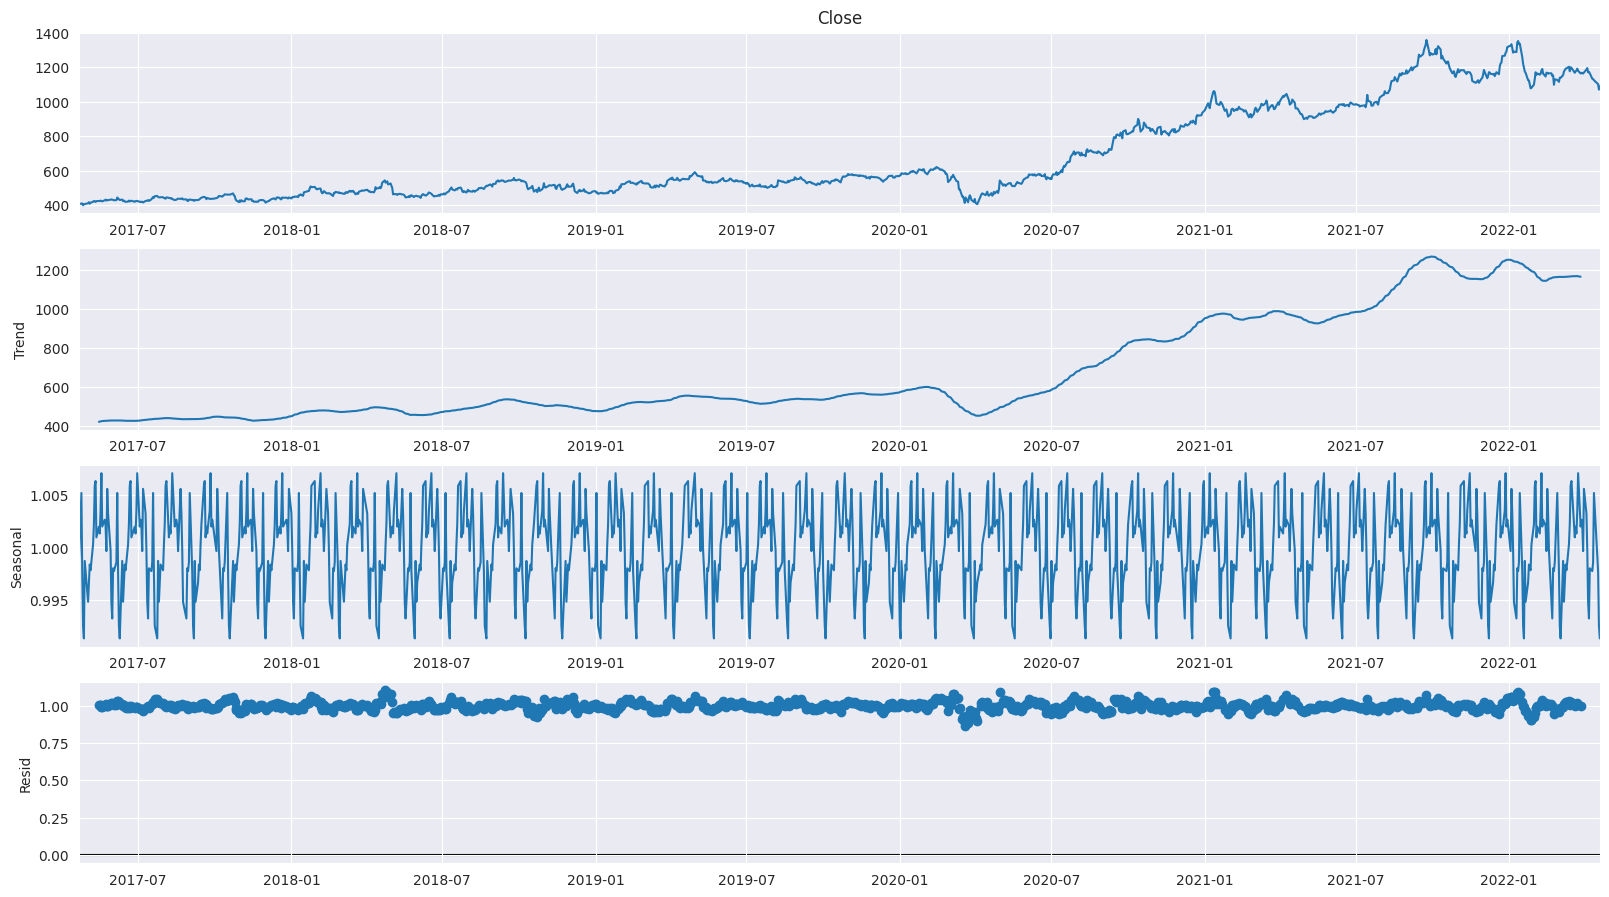

In [35]:
result = seasonal_decompose(data['Close'], model = 'multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.savefig('stationaryData.png')
fig.set_size_inches(16, 9)

### Converting Non-stationary to Stationary Data

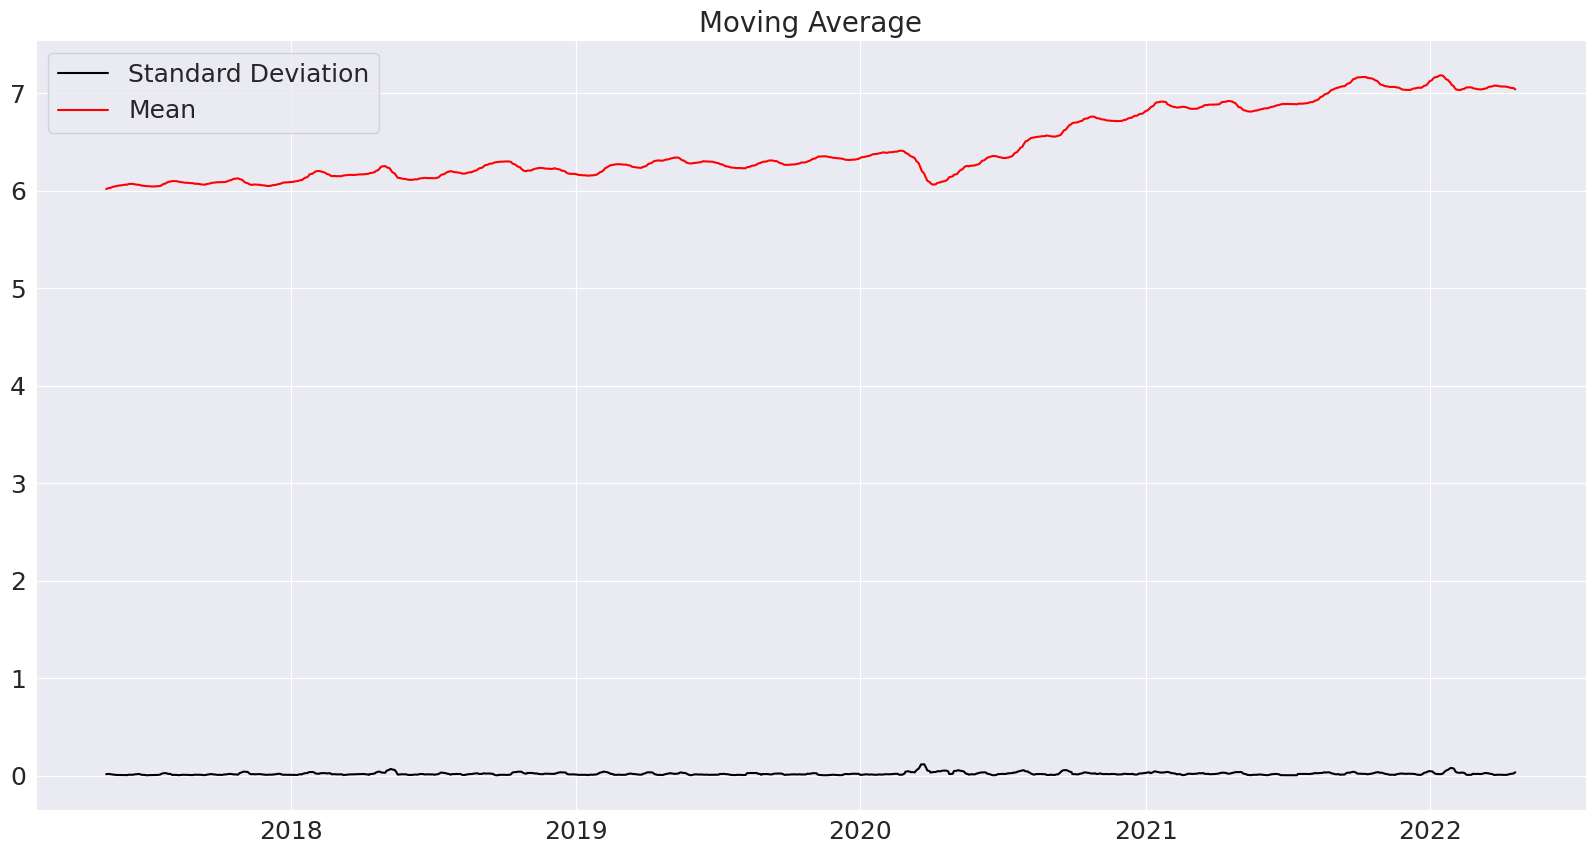

In [36]:
rcParams['figure.figsize'] = 20, 10
data_adj_close_log = np.log(data['Close'])
moving_average = data_adj_close_log.rolling(12).mean()
std_dev = data_adj_close_log.rolling(12).std()
plt.legend(loc = 'best')
plt.title('Moving Average', fontsize = 20)
plt.plot(std_dev, color = "black", label = "Standard Deviation")
plt.plot(moving_average, color = "red", label = "Mean")
plt.legend(fontsize = 18)
plt.tick_params(axis = 'x', labelsize = 18)
plt.tick_params(axis = 'y', labelsize = 18)
plt.show()

#### Now substract the moving average from that, and we apply ADF test.

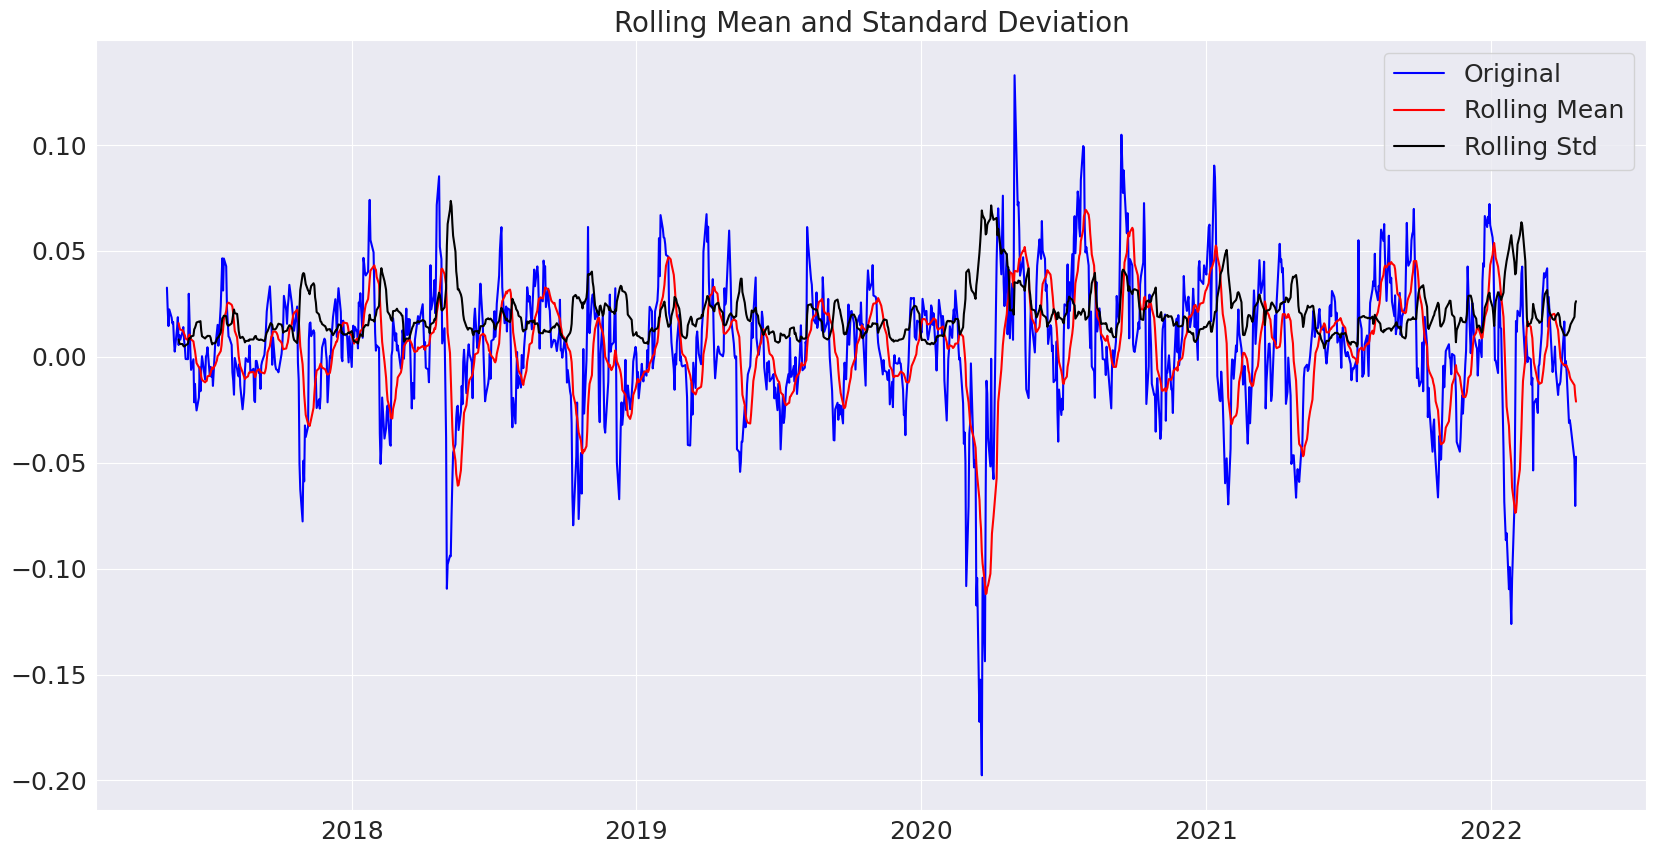

Results of Dicky Fuller Test
Test Statistics               -7.958585e+00
p-value                        2.990744e-12
No. of lags used               2.300000e+01
Number of observations used    1.200000e+03
Critical value (1%)           -3.435811e+00
Critical value (5%)           -2.863952e+00
Critical value (10%)          -2.568054e+00
dtype: float64


In [37]:
data_log_minus_mean = data_adj_close_log - moving_average
data_log_minus_mean.dropna(inplace=True)
test_adf(data_log_minus_mean)

##### It is evident that test statistics is less than the critical values and p<0.05, hence we reject the null hypothesis meaning our time series data is stationary.

### Train-Test Split

#### We split our train test data by the ration of 75:25.

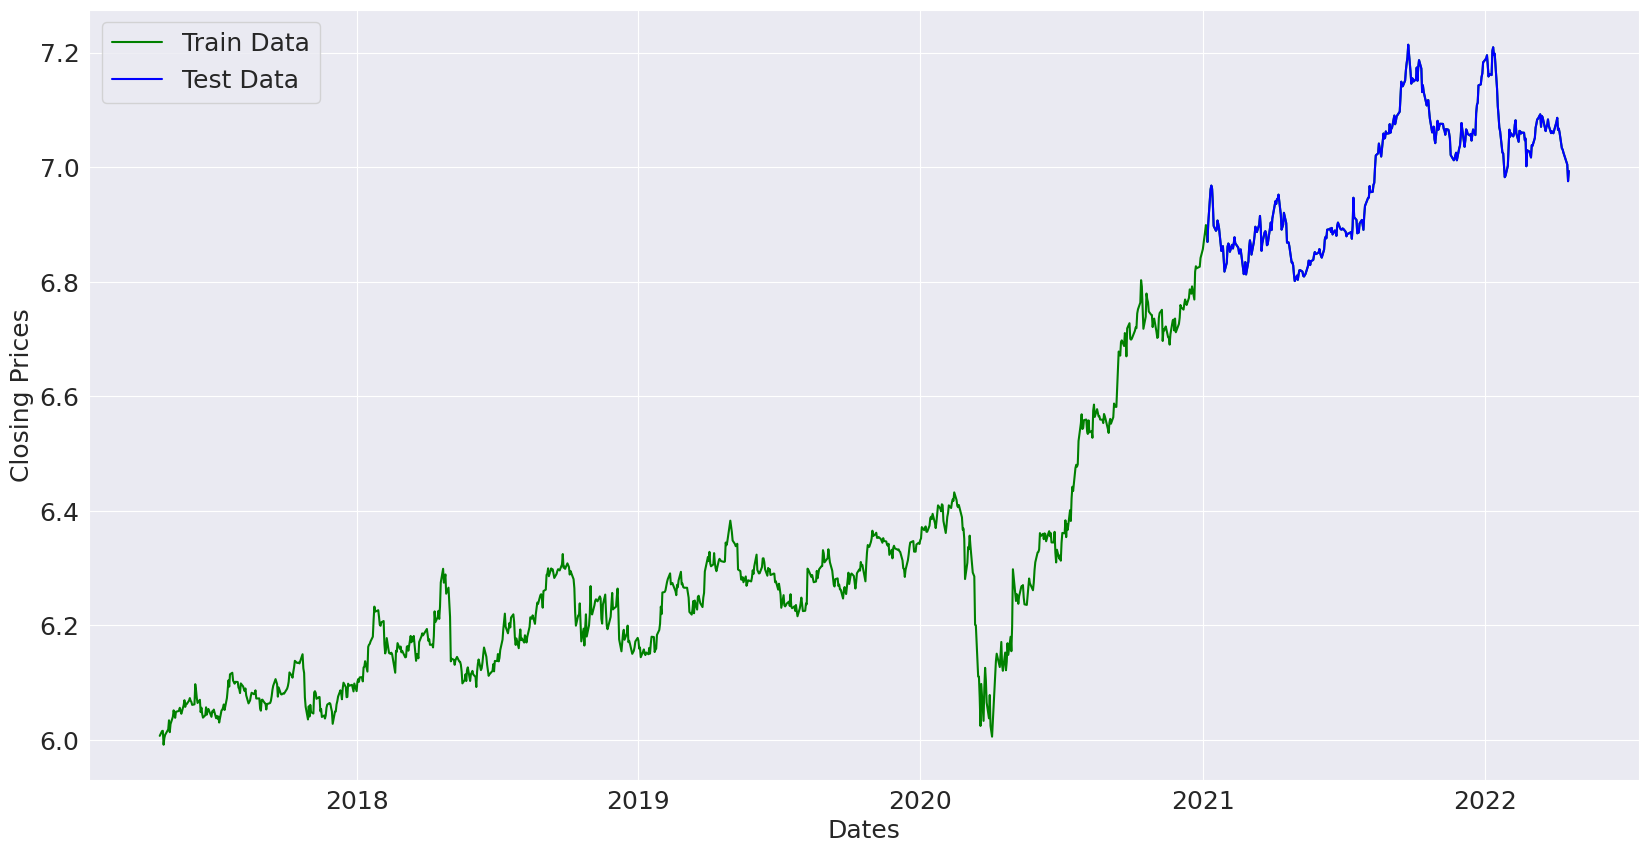

In [38]:
train_data, test_data = data_adj_close_log[:int(len(data_adj_close_log)*0.75)], data_adj_close_log[int(len(data_log_minus_mean)*0.75):]
plt.figure(figsize = (20,10))
plt.xlabel('Dates', fontsize = 18)
plt.ylabel('Closing Prices', fontsize = 18)
plt.plot(data_adj_close_log, 'green', label = 'Train Data')
plt.plot(test_data, 'blue', label = 'Test Data')
plt.legend(fontsize = 18)
plt.tick_params(axis = 'x', labelsize = 18)
plt.tick_params(axis = 'y', labelsize = 18)
plt.savefig('train-test.png')

### Apply auto_arima function

#### auto_arima function helps to find an optimal order for an ARIMA model. It returns the best ARIMA model

In [39]:
model_autoARIMA = auto_arima(train_data,
                             start_p = 0, start_q = 0,
                             test = 'adf',
                             max_p = 7, max_q = 7,
                             start_P = 0, D = 0,
                             m = 1,
                             d = None,
                             seasonal = False,
                             trace = True,
                             error_action = 'ignore',
                             suppress_warnings = True,
                             stepwise = True
                            )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4762.672, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4766.643, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4767.001, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4762.192, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4765.326, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4765.527, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4763.580, Time=2.76 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4766.030, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.804 seconds


In [40]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  926
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2386.501
Date:                Thu, 03 Aug 2023   AIC                          -4767.001
Time:                        04:17:26   BIC                          -4752.512
Sample:                             0   HQIC                         -4761.473
                                - 926                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.709      0.088      -0.000       0.002
ma.L1         -0.0824      0.023     -3.633      0.000      -0.127      -0.038
sigma2         0.0003   8.48e-06     39.641      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               901.01
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,1,0))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [42]:
forecast = fitted.forecast(15, alpha=0.05)
print(forecast.values)

[6.88973349 6.88968309 6.88968699 6.88968669 6.88968671 6.88968671
 6.88968671 6.88968671 6.88968671 6.88968671 6.88968671 6.88968671
 6.88968671 6.88968671 6.88968671]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
# prediction_series = pd.Series(prediction,index = test_data.index)
# fig, ax = plt.subplots(1, 1, figsize = (15, 5))
# ax.plot(data_adj_close_log)
# ax.plot(prediction_series)
# ax.fill_between(prediction_series.index,
#                 cf[0],
#                 cf[1],color='grey',alpha=.3)

In [44]:
prediction, confint = model_autoARIMA.predict(n_periods=test_data.shape[0], return_conf_int=True)

prediction
cf= pd.DataFrame(confint)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


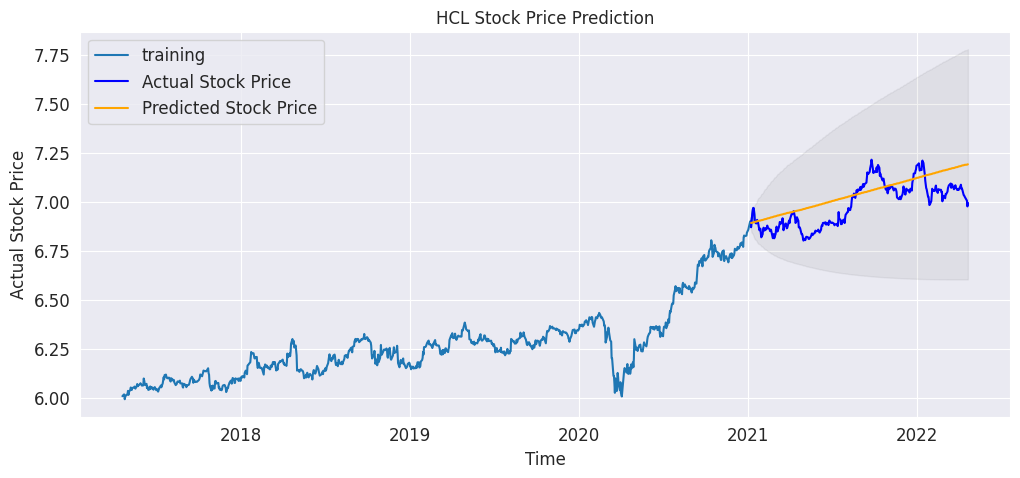

In [45]:
fc, conf = model_autoARIMA.predict(n_periods = test_data.shape[0], return_conf_int = True)

fc_series = pd.Series(fc)

fc_series.index = test_data.index

lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index = test_data.index)

plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, color = 'blue', label = 'Actual Stock Price')
plt.plot(fc_series, color = 'orange', label = 'Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color = 'k', alpha = 0.05)
plt.title('HCL Stock Price Prediction')
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Actual Stock Price', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 12)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.savefig('Forecast.png')
plt.show()

### Performance of the Model

#### To evaluate the model performance, perfomance metrics like Mean Squared Error(MSE), Mean Absolute Error(MAE), Root Mean Squared Error(RMSE), Mean Absolute Percentage Error(MAPE) are used.

In [46]:
mse = mean_squared_error(test_data, fc)
mae = mean_absolute_error(test_data, fc)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(fc - test_data)/ np.abs(test_data))

print('MSE: '+str(mse))
print('MAE: '+str(mae))
print('RMSE: '+str(rmse))
print('MAPE: '+str(mape))

MSE: 0.00803370918155261
MAE: 0.07811002552885458
RMSE: 0.08963096106565303
MAPE: 0.01120845696536436


##### From the above output it is clear that the model is performing really well on the test dataset.